In [2]:
#export 
source("exp/nb_03b.R")

In [4]:
#export
library(mlr)
library(randomForestSRC)
library(ranger)
library(mRMRe)
library(caret)
library(pec)
require(survival)
library(missMethods)
library(MASS)
library(SIS)

## Helper functions

## Load data

In [5]:
dfs = readRDS(paste(data_path,"dfs_filtered.rds"))

### Prepare data

In [6]:
#export
clean_df = function(df){
    if(!is.data.frame(df)) stop("df must be data frame!")
    ind_st = which("survival_time" == colnames(df))
    ind_e  = which("event"         == colnames(df))
    i = first_expr_col(df)
    e = dim(df)[2]
    df[,c(ind_st, ind_e, i:e)]
}

In [7]:
#export
impute_df = purrr::partial(apply_imputation, FUN=median)

In [8]:
#export
impute_and_clean = purrr::compose(impute_df, clean_df)

In [9]:
dfs = map(dfs, impute_and_clean)

## Feature Selection Methods 

In [46]:
#export
rsf_fi = function(df, method){
    φ = as.formula(Surv(survival_time, event)~.)
    m = rfsrc(φ, data = df, 
              ntree=1000, 
              nsplit = 10, 
              mtry = sqrt((dim(df)[2]-2)), 
              nodesize = 3, 
              importance = T)
    vars_selected  = var.select(object = m, method = method, verbose = F)
    vars_selected$topvars
}

### 1) Random Survival Forests (RSF) variable importance

In [25]:
df = clean_df(dfs[[1]])

In [26]:
rsf_fi(df[,1:20], method = "vh.vimp")

[1] "CCNE2"  "GAPDH"  "EFCAB1"

### 2) RSF minimal depth

In [27]:
rsf_fi[df[,1:20], method = "md")

[1] "CCNE2"    "HNRNPAB"  "GAPDH"    "EEF1A1"   "CDT1"     "IPO13"   
 [7] "EFCAB1"   "BORCS5"   "AFAP1"    "RPS28"    "PDE4DIP"  "FAM86FP" 
[13] "SLC35E2A" "LPP"      "TRPV1"    "UGP2"     "PRSS41"   "WIPF3"

### 3) RSF variable hunting

In [28]:
rsf_fi(df[,1:20], method = "vh")

[1] "CDT1"    "PRSS41"  "HNRNPAB" "PDE4DIP"

### 4) Maximally selected rank statistics Random Forests (MSRS RF) variable importance

In [87]:
#export
msrs_rf_fi = function(df, save = FALSE){
    m = ranger(x = df[,-c(1,2)],
           y= Surv(df[,1], df[,2]),
           data = df, 
           splitrule = "maxstat",
           importance = "permutation",
           num.trees = 1000,
           verbose = FALSE
          )
    var_imps = sort(m$variable.importance, decreasing = T)
    if (save==TRUE){
        saveRDS(object = var_imps, file = paste(data_path,"msrs_rf_variable_importances.rds"))
        }
    var_imps[1:200]
}

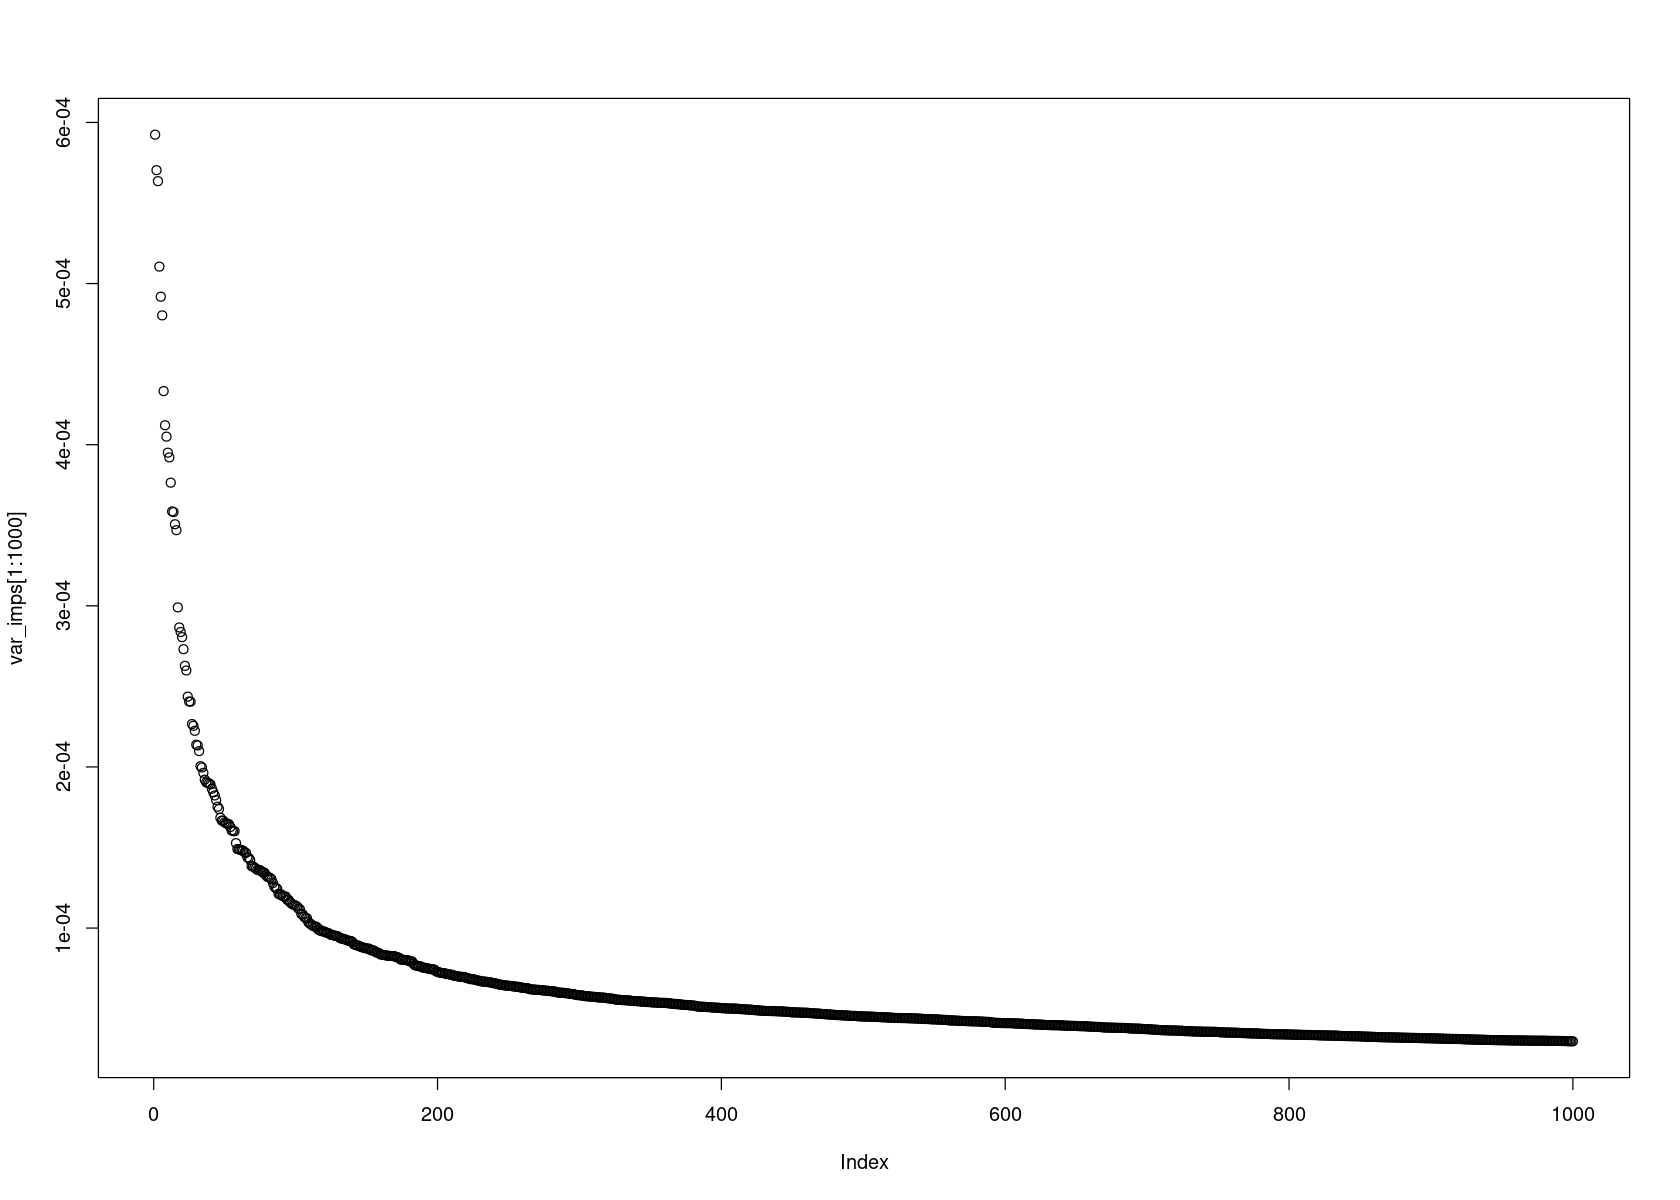

In [209]:
plot(var_imps[1:1000])

### 5) The Minimum Redundancy Maximum Relevance (mRMR) filter

In [108]:
df = dfs[[1]]
df = df[,1:1000]

In [78]:
#export
mrmr_fi = function(df){
    tmp = cbind(Surv(df[,1], df[,2]), df[,-c(1,2)])
    colnames(tmp) = c("Surv", colnames(df)[-c(1,2)])
    data = mRMR.data(tmp)
    m = mRMR.classic(data = data, target_indices = c(1),feature_count = 20)
    data@feature_names[solutions(m)[[1]]]
    }

In [109]:
mrmr_fi(df)

[1] "CCNE2"   "COL4A1"  "HMGCR"   "ZMYND12" "GAPDH"   "ABCC5"   "PDE6B"  
 [8] "GPRIN1"  "DNAI3"   "SLC41A1" "HSPA1L"  "KMT5A"   "ATP10D"  "PPEF1"  
[15] "GSTM4"   "HNRNPAB" "RDH16"   "MLYCD"   "TTC8"    "PTPRS"

### 6) Sequential forward and backward selection

In [15]:
#export
numbers_only = function(x) !grepl("\\D", x)

In [213]:
colnames(dfs[[6]])[1:10]

[1] "survival_time" "event"         "GREM2"         "SUHW2"        
 [5] "39"            "FGB"           "SCARA5"        "NA1"          
 [9] "RAC1"          "NA2"

In [214]:
numbers_only(colnames(dfs[[6]])[1:10])

[1] FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE

In [43]:
#export
sfbs_fi = function(df, save = FALSE){
    cols = colnames(df)
    df = df[,cols[numbers_only(cols)==FALSE]]
    φ = as.formula(paste("Surv(survival_time, event) ~ ", paste(colnames(df)[-c(1,2)], collapse= "+")))
    m = stepAIC(coxph(formula = φ, data = df), direction="backward", trace=FALSE0)
    if (save==TRUE){
        saveRDS(object = m, file = paste(data_path,"sequential_selection_model.rds"))
        }
    names(m$coefficients)
    }

In [48]:
library(h2o)

In [44]:
df = dfs[[1]]

In [45]:
sfbs_fi(df)

ERROR: Error: protect(): protection stack overflow


In [222]:
df = dfs[[6]]
df = df[, 1:100]

In [223]:
sfbs_fi(df)

[1] "GREM2"     "FGB"       "NA1"       "NA2"       "NA3"       "NA4"      
 [7] "NA5"       "NA6"       "GPM6A"     "C11orf38"  "NA7"       "NA9"      
[13] "NA10"      "STAC2"     "JMJD1A"    "NA11"      "ZNF148"    "NA13"     
[19] "NA14"      "SLC15A2"   "NA15"      "SAMD9L"    "NA16"      "SPRY3"    
[25] "KCMF1"     "NA19"      "NA20"      "NA21"      "NA22"      "THSD4"    
[31] "FAM122B"   "ACBD4"     "NA23"      "NA25"      "NA26"      "CRTC2"    
[37] "NA28"      "NA29"      "TTYH1"     "NA30"      "NA31"      "CKAP2L"   
[43] "NA32"      "NA33"      "NA34"      "MS4A1"     "NA36"      "NA37"     
[49] "NA38"      "NA39"      "NA40"      "NA42"      "NA43"      "NA44"     
[55] "NA46"      "NA47"      "RGS5"      "MRPL19"    "NA50"      "IKZF2"    
[61] "LONRF2"    "C14orf173" "RAB3GAP1"  "SLC39A14"  "NDRG4"     "NA52"     
[67] "EPHB2"     "MMD2"      "NA54"      "NA56"      "KIAA1189"

### 7) SIS

In [139]:
names(dfs)

[1] "METABRIC" "GSE11121" "GSE96058" "GSE7390"  "GSE9893"  "NKI"      "TCGA"    
[8] "GSE4922"

In [13]:
fi_sis = vector("list", 7)

In [145]:
saveRDS(object = fi_sis, file = "../data/fi_sis.rds")

In [25]:
#export
sis_fi = function(df){ 
    sis = SIS(as.matrix(df[,-c(1,2)]), 
          Surv(df[,1], df[,2]), 
          family = "cox", 
          penalty = "lasso", 
          tune="aic",
          varISIS='cons',
          standardize = TRUE,
          greedy = TRUE
             )
    colnames(df[,-c(1,2)])[sis$ix]
    }

#### SIS for GSE96058 separately

In [26]:
df = dfs[[3]]
dim(df)

[1]  1102 30862

In [10]:
df_var = sapply(df[3:ncol(df)], var)

In [12]:
length(df_var)

[1] 30860

In [19]:
cols = names(df_var[df_var > 0.75])
length(cols)

[1] 6189

In [27]:
df = df[,c("survival_time", "event",cols)]
dim(df)

[1] 1102 6191

In [28]:
fi = sis_fi(df)

Iter 1 , screening:  10 166 172 231 233 299 507 538 629 666 703 1094 1256 2547 2551 3221 4771 4775 4876 4878 4924 4949 5348 5430 5962 6113 
Iter 1 , selection:  166 172 538 2547 4775 5962 6113 
Iter 1 , conditional-screening:  1573 1713 1801 2856 2862 2883 3493 3503 3520 3531 3534 3553 3608 3633 3654 3727 3776 3786 3833 3856 3887 3889 3947 3961 3964 4815 5222 5308 5341 5374 5415 6092 
Iter 2 , screening:  166 172 538 1573 1713 1801 2547 2856 2862 2883 3493 3503 3520 3531 3534 3553 3608 3633 3654 3727 3776 3786 3833 3856 3887 3889 3947 3961 3964 4775 4815 5222 5308 5341 5374 5415 5962 6092 6113 
Sample splitting attempt:  1 
Iter 1 , screening:  10 166 170 229 231 233 257 266 290 299 301 507 538 629 631 666 686 703 1094 1256 2512 2539 2551 2552 3328 4483 
Iter 1 , selection:  166 229 290 301 538 686 2512 
Iter 1 , conditional-screening:  1741 1756 1792 1796 1799 1810 2856 3488 3566 3610 3611 3635 3668 3673 3712 3724 3730 3739 3745 3780 3806 3809 3839 3851 3942 3945 3949 3957 4810 5251 5

In [29]:
fi

[1] "AF086346" "AK128525" "DQ588543" "HIPK2"    "MIR4461"  "MIR4466" 
 [7] "MIR632"   "MIR637"   "MIR6736"  "MIR6762"

In [45]:
fis = readRDS("../data/fi_sis.rds")

In [47]:
fis[[2]] = fi

In [48]:
fis

[[1]]
[1] "CYP7A1"  "DNMT3A"  "KCMF1"   "RAB9BP1" "RSRC1"  

[[2]]
 [1] "AF086346" "AK128525" "DQ588543" "HIPK2"    "MIR4461"  "MIR4466" 
 [7] "MIR632"   "MIR637"   "MIR6736"  "MIR6762" 

[[3]]
[1] "ARL6IP5" "ESM1"    "SMPX"    "TMEM156" "TUBG1"   "UGT2B4" 

[[4]]
[1] "MAP4K5" "CADPS"  "DIO2"   "FOXF2" 

[[5]]
[1] "UGCGL1"   "SEMA5B"   "RPL41"    "ZNF533"   "C1RL"     "NXN"      "STARD13" 
[8] "C20orf24"

[[6]]
[1] "STOML3"    "AC1041171" "SFTA3"     "AC0112871" "LCE1F"     "AC1081591"
[7] "RNU61161P" "RNA5SP101"

[[7]]
[1] "C19orf53" "CXCL5"    "POLR2I"   "PRR16"

In [49]:
saveRDS(object = fis, file = "../data/fi_sis.rds")

### 8) Baseline: univariable Cox

In [199]:
#export
get_formula = function(x) {as.formula(paste('Surv(survival_time, event)~',x))}

In [200]:
#export
get_cox = function(φ){
    m = try(coxph(φ, data = df), silent = TRUE)
    if (class(m) == "try-error") {
        coxph(as.formula('Surv(survival_time, event)~NA1'), data = df)}
    else{
        coxph(φ, data = df)
    }
}

In [201]:
#export
get_p_val = function(m){summary(m)$coefficients[[5]]}

In [202]:
#export
cox_fi = function(df){
    φs = sapply(colnames(df[3:ncol(df)]), get_formula)
    ms = lapply(φs, get_cox)
    πs = lapply(ms, get_p_val)
    πs_adjusted = sort(p.adjust(p = πs, method = "bonferroni"))
    πs_adjusted[πs_adjusted < 0.05]
    }

In [203]:
df = dfs[[6]]

In [205]:
cox_fi(df[,1:100])

NA45        NDRG4 
0.0005443406 0.0006619115

### Feature selection for all methods and all datasets

#### For NKI and TCGA, for mrmr_fi, pre-filtering with variance threshold = 0.75 was done.

In [38]:
var_filter = function(df, thresh){
    df_var = sapply(df[3:ncol(df)], var)
    cols = names(df_var[df_var > thresh])
    df[,c("survival_time", "event",cols)]
}

In [12]:
names(dfs)

[1] "METABRIC" "GSE11121" "GSE96058" "GSE7390"  "GSE9893"  "NKI"      "TCGA"    
[8] "GSE4922"

In [10]:
feature_selections = readRDS("../data/feature_selections.rds")

In [21]:
df = dfs[[7]]

In [22]:
dim(df)

[1]   169 38141

In [39]:
df = var_filter(dfs[[7]], 0.75)
dim(df)

[1]   169 27357

In [40]:
fs = mrmr_fi(df)

In [41]:
fs

[1] "TRPV3"     "GALNTL6"   "TMEM225B"  "TUSC8"     "AC1048251" "ITIH6"    
 [7] "LRRC37A6P" "RF0001930" "TCERG1L"   "GALNT16"   "ADAMTS3"   "SLC7A4"   
[13] "C1QL1"     "CEP170P1"  "AL1617161" "AC0237902" "AC0055321" "BRINP1"   
[19] "TRAJ7"     "ENPP3"

In [42]:
feature_selections[[6,7]] = list(fs)

In [43]:
saveRDS(feature_selections, file = "../data/feature_selections.rds")

#### rfsrc separately 

In [279]:
feature_selections = readRDS("../data/feature_selections.rds")

#### GSE11121, 'GSE7390', 'GSE9893', 'NKI', 'TCGA', 'GSE4922':
    m = rfsrc(φ, data = df, 
              ntree=10, 
              nsplit = 10, 
              mtry = sqrt((dim(df)[2]-2)), 
              nodesize = 3,
              conservative = "low",#c("medium", "low", "high"),
              importance = T)

In [255]:
rsf_fi = function(df, method){
    φ = as.formula(Surv(survival_time, event)~.)
    m = rfsrc(φ, data = df, 
              ntree=1000, 
              nsplit = 10, 
              mtry = sqrt((dim(df)[2]-2)), 
              nodesize = 3,
              conservative = "low",#c("medium", "low", "high")
              importance = "permute")
    vars_selected  = var.select(object = m, method = method, verbose = F,
                               fast=TRUE)
    vars_selected$topvars
}

In [262]:
for (i in 1:8){
    df = var_filter(dfs[[i]], 0.75)
    print(dim(df))
    feature_selections[[4,i]] = list(rsf_fi(df, method = "vh"))
    saveRDS(feature_selections, file = "../data/feature_selections.rds")
    print(length(feature_selections[[4,i]]))
}

[1] 683 620
[1] 1
[1] 120 487
[1] 1
[1] 1102 6191
[1] 1
[1] 134 798
[1] 1
[1]   86 3489
[1] 1
[1] 179   2


ERROR: Error in rfsrc(φ, data = df, ntree = 1000, nsplit = 10, mtry = sqrt((dim(df)[2] - : something seems wrong: your formula did not define any x-variables


In [281]:
saveRDS(feature_selections, file = "../data/feature_selections.rds")

In [249]:
#export
rsf_vi_fi = purrr::partial(rsf_fi, method = "vh.vimp")
rsf_md_fi = purrr::partial(rsf_fi, method = "md")     
rsf_vh_fi = purrr::partial(rsf_fi, method = "vh")     

In [255]:
#export
FI = list(
    cox_fi     = cox_fi     ,
    rsf_vi_fi  = rsf_vi_fi  ,
    rsf_md_fi  = rsf_md_fi  ,
    rsf_vh_fi  = rsf_vh_fi  ,
    msrs_rf_fi = msrs_rf_fi ,
    mrmr_fi    = mrmr_fi    ,
    sfbs_fi    = sfbs_fi    ,
    sis_fi     = sis_fi     
)

In [256]:
df = dfs[[1]]
df = df[,1:100]

In [257]:
FI[[1]](df)

CCNE2        GAPDH      HNRNPAB         CDT1         AUP1      COL17A1 
1.008898e-08 7.279329e-07 1.519303e-06 1.866941e-05 3.660065e-03 3.813121e-03 
      EEF1A1        IPO13 
1.732676e-02 3.927465e-02

#### Main loop

In [68]:
methods =  c("Univariable_cox_filter",
             "RSF_variable_importance", "RSF_minimal_depth", "RSF_variable_hunting",
             "MSRS_RF_variable_importance", "mRMR", "Sequential_selection", "SIS"
            )

In [231]:
feature_selections = tibble(
    METABRIC = list(NA,NA,NA,NA,NA,NA,NA,NA,NA),
    GSE11121 = list(NA,NA,NA,NA,NA,NA,NA,NA,NA),
    GSE96058 = list(NA,NA,NA,NA,NA,NA,NA,NA,NA),
    GSE7390  = list(NA,NA,NA,NA,NA,NA,NA,NA,NA),
    GSE9893  = list(NA,NA,NA,NA,NA,NA,NA,NA,NA),
    NKI      = list(NA,NA,NA,NA,NA,NA,NA,NA,NA),
    TCGA     = list(NA,NA,NA,NA,NA,NA,NA,NA,NA),
    GSE4922  = list(NA,NA,NA,NA,NA,NA,NA,NA,NA)
)
rownames(feature_selections) = methods

In [232]:
for (i in 1:length(dfs)){
    df = dfs[[i]]
    df = df[,1:10]

    cat(paste0('Processing ', names(dfs)[i],'\r'))
    
    feature_selections[[1,i]] = list(cox_fi(df)                    )
    feature_selections[[2,i]] = list(rsf_fi(df, method = "vh.vimp"))
    feature_selections[[3,i]] = list(rsf_fi(df, method = "md")     ) 
    feature_selections[[4,i]] = list(rsf_fi(df, method = "vh")     ) 
    feature_selections[[5,i]] = list(msrs_rf_fi(df)                ) 
    feature_selections[[6,i]] = list(mrmr_fi(df)                   )
    feature_selections[[7,i]] = list(sfbs_fi(df)                   )
    feature_selections[[8,i]] = list(sis_fi(df)                    )
}

ERROR: Error: Subsetting can not be done on a ‘list’; only to an environment: ‘feature_selections[[1, i]]’


In [228]:
feature_selections

METABRIC,GSE11121,GSE96058,GSE7390,GSE9893,NKI,TCGA,GSE4922
<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>
"5.942310e-08, 1.414429e-03, 3.206094e-03, 6.507428e-03, 1.635911e-02",,,,,0.02044616,,
"EEF1A1, RPS28","AAAS, A2M","A1BG, A1CF","AAAS , AAGAB","RRM1, SLK","GREM2, SUHW2","C1orf112, TSPAN6","A2M , A4GALT"
"GAPDH , EEF1A1 , RPS28 , EFCAB1 , IPO13 , FAM86FP , SLC35E2A, PRSS41","A4GALT, AAAS , A2M , AAGAB , AADAC , A1CF","A2MAS1 , A2ML1 , A2M , A1BG , A3GALT2, A1BGAS1, A2MP1 , A1CF","AAAS , A4GNT , A2M , AAGAB , A4GALT, AADAC , A1CF","SLK , GZMK , UBN1 , RRM1 , MAGEE1, FRK","SCARA5, GREM2 , SUHW2 , FGB , NA2 , RAC1 , 39 , NA1","CFH , TSPAN6 , FGR , C1orf112, DPM1 , FUCA2","AACS , A4GALT, A4GNT , AAAS"
"SLC35E2A, EFCAB1","AADAC, AAAS","A2MP1 , A1BGAS1","A2M , A4GNT","FRK , RRM1","39 , SCARA5","SCYL3 , C1orf112","A4GNT , A4GALT"
"0.0284710795, 0.0103151630, 0.0079912261, 0.0066661709, 0.0017185105, 0.0006626312, -0.0008261443, -0.0016522565, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA","1.917200e-02, 6.442290e-03, 3.527713e-03, 1.862265e-03, 6.000563e-04, -1.683833e-05, -4.799272e-03, -5.081845e-03, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA","0.0171934695, 0.0067665393, 0.0018198010, 0.0013261353, 0.0007693522, -0.0007945677, -0.0021641382, -0.0042535108, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA","0.0061383549, 0.0053188327, 0.0030106810, 0.0023756392, -0.0001742927, -0.0006423078, -0.0010880361, -0.0016418240, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA

# Prepare dataframes from features selections

In [28]:
select_df = function(df, feature_selections){
    fs = unlist(feature_selections)
    if(class(fs)=="numeric"){
        fs = names(fs)
    }
    df[,c("survival_time", "event", fs)]
}

In [13]:
FS = readRDS("../data/feature_selections.rds")
FS = FS[-c(7),]
dim(FS)

[1] 7 8

In [14]:
rownames(FS) =  c("Univariable_cox_filter",
                  "RSF_variable_importance", "RSF_minimal_depth", "RSF_variable_hunting",
                  "MSRS_RF_variable_importance", "mRMR", "SIS")

In [15]:
dfs_feature_selections = vector("list", length(dfs))

In [45]:
for (i in 1:length(dfs)){
    df = dfs[[i]]
    select_genes = purrr::partial(select_df, df = df)
    dfs_feature_selections[[i]] = map(1:7, function(ind) select_genes(FS[[ind, i]])) 
}

In [46]:
map(dfs_feature_selections, length)

[[1]]
[1] 7

[[2]]
[1] 7

[[3]]
[1] 7

[[4]]
[1] 7

[[5]]
[1] 7

[[6]]
[1] 7

[[7]]
[1] 7

[[8]]
[1] 7

In [55]:
map(dfs_feature_selections[[1]], function(x) (dim(x)-2))

[[1]]
[1] 681 384

[[2]]
[1] 681  57

[[3]]
[1] 681   3

[[4]]
[1] 681  29

[[5]]
[1] 681 200

[[6]]
[1] 681  20

[[7]]
[1] 681  26

## Save data

In [56]:
saveRDS(dfs_feature_selections, paste(data_path,"dfs_feature_selections.rds"))

## Export code

In [1]:
system("python3 notebook2script.py 04_feature_selections.ipynb")